# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from script.descriptor import get_acsf_dict,GetRdkitDescriptorsdict,get_fp_dict,get_oh,des_std
from script.model import  models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
tmp_df = pd.read_csv('../data1/data1.csv')
lig_smiles = np.array(tmp_df['Ligand'].to_list())
add_smiles =  np.array(tmp_df['Additive'].to_list())
base_smiles =  np.array(tmp_df['Base'].to_list())
ar_ha_smiles =  np.array(tmp_df['Aryl halide'].to_list())
labels =  np.array(tmp_df['Output'].to_list())
labels_std = (labels - labels.min())/(labels.max()-labels.min())
lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))
ar_smi_set=ar_ha_smi_set
lig_smi_set.sort()
add_smi_set.sort()
base_smi_set.sort()
ar_ha_smi_set.sort()

# Generate Descriptor

In [3]:
species=['N', 'H', 'C', 'P',"F","Cl","Br","O","I","S","Si"]
acsf_lig_all_dict = get_acsf_dict(lig_smi_set,species=species)
acsf_base_all_dict =get_acsf_dict(base_smi_set,species=species)
acsf_ar_all_dict = get_acsf_dict(ar_ha_smi_set,species=species)
acsf_add_all_dict= get_acsf_dict(add_smi_set,species=species)

rdkit_lig_all_dict = GetRdkitDescriptorsdict(lig_smi_set)
rdkit_add_all_dict= GetRdkitDescriptorsdict(add_smi_set)
rdkit_base_all_dict = GetRdkitDescriptorsdict(base_smi_set)
rdkit_ar_all_dict = GetRdkitDescriptorsdict(ar_ha_smi_set)

fp_lig_all_dict = get_fp_dict(lig_smi_set)
fp_add_all_dict= get_fp_dict(add_smi_set)
fp_base_all_dict = get_fp_dict(base_smi_set)
fp_ar_all_dict = get_fp_dict(ar_ha_smi_set)

lig_oh_desc=get_oh(lig_smiles)
add_oh_desc=get_oh(add_smiles)
base_oh_desc=get_oh(base_smiles)
ar_oh_desc=get_oh(ar_ha_smiles)

# Generate Reaction Feature

In [4]:
num=3955

acsf_total_lig = np.array([[acsf_lig_all_dict[tmp_smi]] for tmp_smi in lig_smiles]).reshape(num,-1)
acsf_total_add = np.array([[acsf_add_all_dict[tmp_smi]] for tmp_smi in add_smiles]).reshape(num,-1)
acsf_total_base = np.array([[acsf_base_all_dict[tmp_smi]] for tmp_smi in base_smiles]).reshape(num,-1)
acsf_total_ar = np.array([[acsf_ar_all_dict[tmp_smi]] for tmp_smi in ar_ha_smiles]).reshape(num,-1)
acsf_react_feat = np.concatenate([acsf_total_lig,acsf_total_add,acsf_total_base,acsf_total_ar],axis = 1)
acsf_react_feat_std=des_std(acsf_react_feat)

rdkit_total_lig = np.array([[rdkit_lig_all_dict[tmp_smi]] for tmp_smi in lig_smiles]).reshape(num,-1)
rdkit_total_add = np.array([[rdkit_add_all_dict[tmp_smi]] for tmp_smi in add_smiles]).reshape(num,-1)
rdkit_total_base = np.array([[rdkit_base_all_dict[tmp_smi]] for tmp_smi in base_smiles]).reshape(num,-1)
rdkit_total_ar = np.array([[rdkit_ar_all_dict[tmp_smi]] for tmp_smi in ar_ha_smiles]).reshape(num,-1)
rdkit_react_feat = np.concatenate([rdkit_total_lig,rdkit_total_add,rdkit_total_base,rdkit_total_ar],axis = 1)
rdkit_react_feat_std=des_std(rdkit_react_feat)

fp_total_lig = np.array([[fp_lig_all_dict[tmp_smi]] for tmp_smi in lig_smiles]).reshape(num,-1)
fp_total_add = np.array([[fp_add_all_dict[tmp_smi]] for tmp_smi in add_smiles]).reshape(num,-1)
fp_total_base = np.array([[fp_base_all_dict[tmp_smi]] for tmp_smi in base_smiles]).reshape(num,-1)
fp_total_ar = np.array([[fp_ar_all_dict[tmp_smi]] for tmp_smi in ar_ha_smiles]).reshape(num,-1)
fp_react_feat = np.concatenate([fp_total_lig,fp_total_add,fp_total_base,fp_total_ar],axis = 1)
fp_react_feat_std=des_std(fp_react_feat)

oh_react_feat = np.concatenate([lig_oh_desc,add_oh_desc,base_oh_desc,ar_oh_desc],axis = 1)
oh_react_feat_std=des_std(oh_react_feat)
descs = [oh_react_feat_std,rdkit_react_feat_std,fp_react_feat_std,acsf_react_feat_std]
model_names = ['Ada','BG','DT','ET','GB','KNR','KRR','LSVR','RF','Ridge','SVR','XGB','NN']
desc_names = ['OH','Rdkit','MF','ACSFs']

In [5]:
np.save('./data/data1_oh_react_feat_std.npy',oh_react_feat_std)
np.save('./data/data1_rdkit_react_feat_std.npy',rdkit_react_feat_std)
np.save('./data/data1_fp_react_feat_std.npy',fp_react_feat_std)
np.save('./data/data1_acsf_react_feat_std.npy',acsf_react_feat_std)

# Tain Model

In [6]:
np.random.seed(1000)
shuffle = np.array(list(range(num)))
np.random.shuffle(shuffle)
train_index = shuffle[:2768]
val_index = shuffle[2768:]

In [7]:
performance_dict = {}
for model,model_name in zip(models,model_names):
    for desc,desc_name in zip(descs,desc_names): 
        all_r2 = []
        all_pearsr = []
        all_mae = []
        all_rmse= []
        repeat_pred = []
        repeat_test = []
        for i in range(10):            
            train_x,test_x = desc[train_index],desc[val_index]
            train_y,test_y = labels_std[train_index],labels_std[val_index]
            model.fit(train_x,train_y)
            test_pred = model.predict(test_x)*(labels.max()-labels.min())+labels.min()
            test_y=test_y*(labels.max()-labels.min())+labels.min()
            repeat_pred.append(test_pred)
            repeat_test.append(test_y)
            r2 = r2_score(test_y,test_pred)
            pearsr = pearsonr(test_y,test_pred)
            mae = mean_absolute_error(test_y,test_pred)
            rmse=(mean_squared_error(test_y,test_pred))**(0.5)
            all_r2.append(r2)
            all_pearsr.append(pearsr[0])
            all_mae.append(mae)
            all_rmse.append(rmse)
        performance_dict['%s-%s'%(model_name,desc_name)] = [np.mean(all_r2),np.mean(all_pearsr),np.mean(all_mae),
                                                            np.mean(all_rmse),repeat_pred[np.argmax(all_r2)],repeat_test[np.argmax(all_r2)]]
        print('Model: %5s, Descriptor: %15s: R2: %.4f, MAE: %.4f, RMSE: %.4f, Pearson R: %.4f'%(
        model_name,desc_name,np.mean(all_r2),np.mean(all_mae),np.mean(all_rmse),np.mean(all_pearsr)))

Model:   Ada, Descriptor:              OH: R2: 0.8950, MAE: 5.5269, RMSE: 8.7670, Pearson R: 0.9467
Model:   Ada, Descriptor:           Rdkit: R2: 0.9270, MAE: 4.8133, RMSE: 7.3124, Pearson R: 0.9632
Model:   Ada, Descriptor:              MF: R2: 0.9177, MAE: 4.8023, RMSE: 7.7597, Pearson R: 0.9584
Model:   Ada, Descriptor:           ACSFs: R2: 0.9210, MAE: 4.9782, RMSE: 7.6082, Pearson R: 0.9601
Model:    BG, Descriptor:              OH: R2: 0.7127, MAE: 11.6920, RMSE: 14.5099, Pearson R: 0.8712
Model:    BG, Descriptor:           Rdkit: R2: 0.7301, MAE: 11.1030, RMSE: 14.0651, Pearson R: 0.8741
Model:    BG, Descriptor:              MF: R2: 0.7716, MAE: 9.8283, RMSE: 12.9359, Pearson R: 0.8882
Model:    BG, Descriptor:           ACSFs: R2: 0.7374, MAE: 10.9476, RMSE: 13.8709, Pearson R: 0.8764
Model:    DT, Descriptor:              OH: R2: 0.8129, MAE: 7.0362, RMSE: 11.7096, Pearson R: 0.9074
Model:    DT, Descriptor:           Rdkit: R2: 0.8247, MAE: 6.7148, RMSE: 11.3331, Pearson R

# Results of Models

<AxesSubplot:>

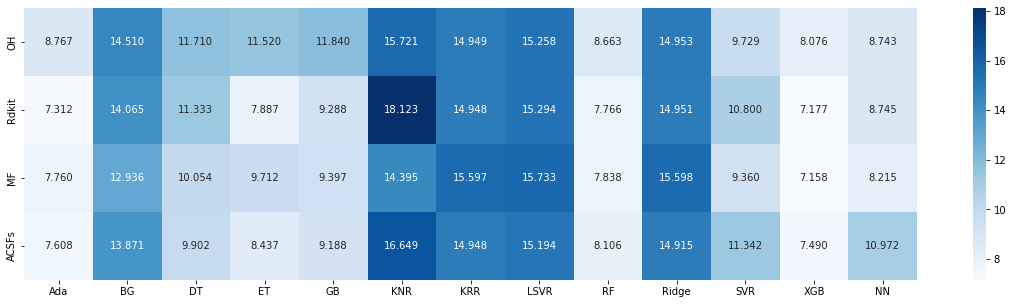

In [8]:
r2_map = np.zeros((len(desc_names),len(model_names)))
for i,m in enumerate(model_names):
    for j,d in enumerate(desc_names):
        r2_map[j,i] = performance_dict['%s-%s'%(m,d)][3]
fig = plt.figure(figsize=(20,5))
sns.heatmap(r2_map,annot=True,fmt='.3f',xticklabels=model_names,yticklabels=desc_names,cmap='Blues')

In [9]:
np.save('./data/data1_cus_result10.npy',performance_dict)